In [4]:
import geopandas as gpd
import pandas as pd
import shapely
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point, LineString
from math import radians, sin, cos, sqrt, atan2, asin, atan

print("All packages are working!")


All packages are working!


In [2]:
pd.reset_option("all")

C:\Users\Admin\AppData\Local\Temp\ipykernel_19208\3365680546.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\Admin\AppData\Local\Temp\ipykernel_19208\3365680546.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


### GPS truck ภาคกลาง

![image-2.png](attachment:image-2.png)

In [5]:
df = pd.read_parquet(r"D:\Decarbonization Project\CleanedData\cleaned_merged_truckdata.parquet")


In [4]:
df.head()

,unitid,utc_ts,lat,lon,speed,typecode
0,00300170000000T015820451233,2024-10-31 23:58:35,14.373698,100.021311,0,7
1,00300170000000T015820710404,2024-10-31 23:58:14,13.779333,100.686003,0,7
2,00300170000000T015820731682,2024-10-31 23:58:48,13.702786,100.822846,0,7
3,00300170000000T015830332337,2024-10-31 23:58:55,13.028070,100.936436,0,6
4,00300170000000T015830332421,2024-10-31 23:58:38,12.750050,101.178588,0,6


In [5]:
df_over_speed = df[df['speed'] >= 80]


In [ ]:
df_over_speed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342291 entries, 124 to 102640906
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   unitid    342291 non-null  object 
 1   utc_ts    342291 non-null  object 
 2   lat       342291 non-null  float64
 3   lon       342291 non-null  float64
 4   speed     342291 non-null  int64  
 5   typecode  342291 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 18.3+ MB


In [7]:
sample_df = df.sample(frac=0.3, random_state=42)
sample_df

,unitid,utc_ts,lat,lon,speed,typecode
62929244,040000400000000143200384225,2024-11-01 12:45:42,13.078635,100.990330,0,7
41890055,114000400000868825064297824,2024-11-01 08:05:44,14.147753,100.643235,0,7
29076813,001000800000000115870118537,2024-11-01 05:37:55,14.291507,100.819930,43,7
19051243,104000100000016002050031803,2024-11-01 03:46:24,12.680158,101.122237,1,7
58995614,195000100000868998037481484,2024-11-01 11:46:55,14.104495,100.632605,0,7
...,...,...,...,...,...,...
100387482,195000600000359857084200211,2024-11-01 23:25:34,13.780060,100.216490,0,8
13793386,001001200000010148600000024,2024-11-01 02:49:11,13.075659,100.927055,33,7
51678851,003000900000000011975002910,2024-11-01 10:04:46,13.779892,100.364826,0,7
66128872,084000400000000242181259045,2024-11-01 13:35:12,13.561345,100.586117,0,7


In [6]:
# Step 2: Transform coordinates to a NumPy array
coordinates_array = df_over_speed[['lat', 'lon']].to_numpy()
print("Coordinates as Array:")
print(coordinates_array)

# Step 3: Create Point geometries from lat/lon
geometry = [Point(xy) for xy in zip(df_over_speed['lon'], df_over_speed['lat'])]

# Step 4: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_over_speed, crs="EPSG:4326", geometry=geometry)  # EPSG:4326 is WGS 84 (latitude/longitude)

# Step 5: (Optional) Transform CRS to UTM (e.g., EPSG:32647 for WGS 84 UTM Zone 47N)
gdf_utm = gdf.to_crs("EPSG:32647")  # Change to your desired CRS

# Step 6: Print results
print("GeoDataFrame with WGS 84:")
print(gdf.head())
print("\nGeoDataFrame with UTM (EPSG:32647):")
print(gdf_utm.head())

traj = gdf_utm['geometry'].to_numpy()
traj
gdf_utm


Coordinates as Array:
[[ 14.33315  100.84963 ]
 [ 13.757278 101.39932 ]
 [ 12.831681 101.127295]
 ...
 [ 13.628111 100.420828]
 [ 14.367187 100.878426]
 [ 13.850682 100.448592]]
GeoDataFrame with WGS 84:
                           unitid                      utc_ts        lat  \
124   093000100000000013300000112         2024-10-31 23:59:02  14.333150   
346   001000800000000114940103124         2024-10-31 23:59:35  13.757278   
390   043001300000000MTG01D000445  2024-10-31 23:59:46.046000  12.831681   
855   1200003000000000000L1000876         2024-10-31 23:59:50  14.329225   
1233  001001200000011288700000001         2024-10-31 23:59:58  13.106915   

             lon  speed  typecode                    geometry  
124   100.849630     80         5  POINT (100.84963 14.33315)  
346   101.399320     81         7  POINT (101.39932 13.75728)  
390   101.127295     91         8   POINT (101.1273 12.83168)  
855   100.613056     81         8  POINT (100.61306 14.32922)  
1233  101.166890   

,unitid,utc_ts,lat,lon,speed,typecode,geometry
124,093000100000000013300000112,2024-10-31 23:59:02,14.333150,100.849630,80,5,POINT (699482.486 1585368.861)
346,001000800000000114940103124,2024-10-31 23:59:35,13.757278,101.399320,81,7,POINT (759441.779 1522175.105)
390,043001300000000MTG01D000445,2024-10-31 23:59:46.046000,12.831681,101.127295,91,8,POINT (730889.381 1419474.327)
855,1200003000000000000L1000876,2024-10-31 23:59:50,14.329225,100.613056,81,8,POINT (673964.628 1584743.639)
1233,001001200000011288700000001,2024-10-31 23:59:58,13.106915,101.166890,80,8,POINT (734930.096 1449966.861)
...,...,...,...,...,...,...,...
102640058,006001600000864606045851051,2024-11-01 23:59:32,14.423490,100.893830,80,5,POINT (704168.889 1595403.729)
102640568,00300180000000T015820821655,2024-11-01 23:57:53,13.702709,100.406672,83,8,POINT (652114.51 1515290.193)
102640586,00300180000000T015830851155,2024-11-01 23:57:52,13.628111,100.420828,84,6,POINT (653693.945 1507046.931)
102640634,003000900000000011970900368,2024-11-01 23:58:54,14.367187,100.878426,93,8,POINT (702558.494 1589160.111)


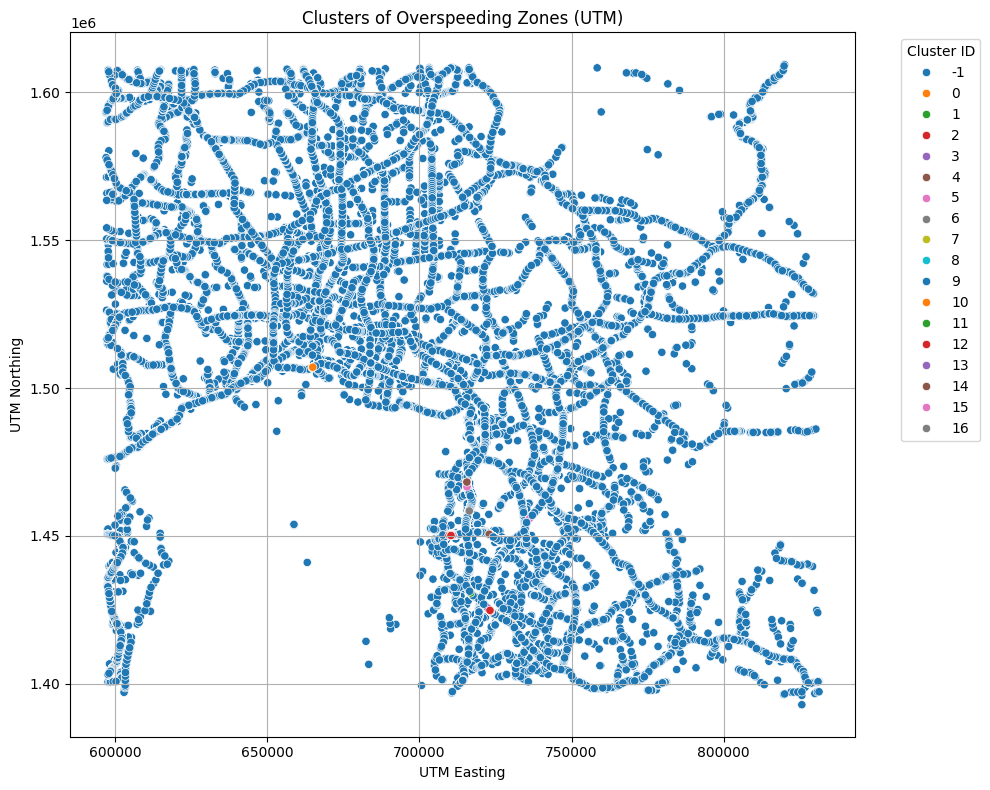

📌 Overspeeding จุดที่พบในแต่ละคลัสเตอร์:
cluster
-1     331850
 6       1462
 0       1443
 2       1015
 3        846
 13       653
 1        647
 4        558
 7        512
 9        489
 14       459
 12       454
 5        369
 15       350
 11       340
 10       337
 8        268
 16       239
Name: count, dtype: int64


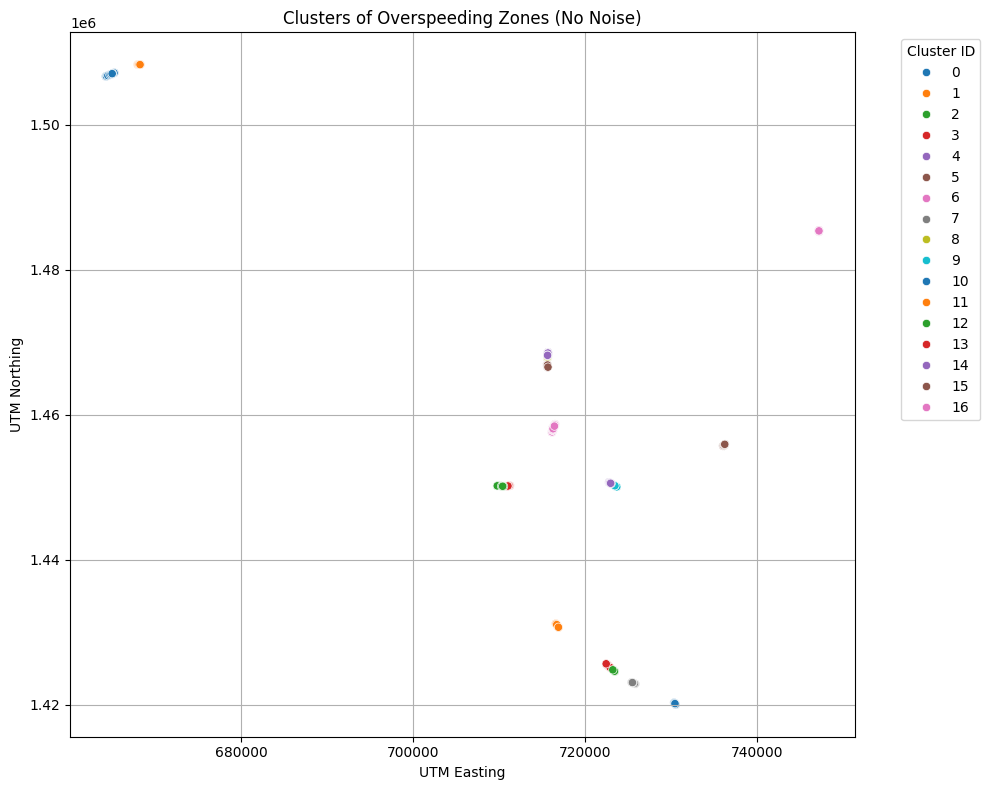

📌 Overspeeding จุดที่พบในแต่ละคลัสเตอร์ (หลังจากกรอง Noise):
cluster
6     1462
0     1443
2     1015
3      846
13     653
1      647
4      558
7      512
9      489
14     459
12     454
5      369
15     350
11     340
10     337
8      268
16     239
Name: count, dtype: int64


In [7]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
#import seaborn as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# ===== 1. กรองเฉพาะจุดที่ขับเร็วเกิน 80 km/h =====
overspeed_df = gdf_utm

# ===== 2. เตรียมข้อมูลพิกัด UTM (ไม่ใช้ lat/lon เพราะ UTM เป็น metric แล้ว) =====
coords = overspeed_df.geometry.apply(lambda p: (p.x, p.y)).tolist()

# ===== 3. Cluster ด้วย DBSCAN =====
# eps=100 (เมตร), min_samples=3 จุดใกล้กันจึงเป็นกลุ่ม
db = DBSCAN(eps=100, min_samples=200).fit(coords)
overspeed_df['cluster'] = db.labels_

# ===== 4. แสดงผลบนกราฟ =====
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=overspeed_df.geometry.x,
    y=overspeed_df.geometry.y,
    hue=overspeed_df['cluster'],
    palette='tab10',
    legend='full'
)
plt.title('Clusters of Overspeeding Zones (UTM)')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.grid(True)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===== 5. สรุปผล =====
print("📌 Overspeeding จุดที่พบในแต่ละคลัสเตอร์:")
print(overspeed_df['cluster'].value_counts())

# ===== 6. กรอง Noise ออกจากข้อมูล =====
no_noise_df = overspeed_df[overspeed_df['cluster'] != -1]

# ===== 7. แสดงผลกราฟใหม่ที่ไม่มี Noise =====
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=no_noise_df.geometry.x,
    y=no_noise_df.geometry.y,
    hue=no_noise_df['cluster'],
    palette='tab10',
    legend='full'
)
plt.title('Clusters of Overspeeding Zones (No Noise)')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.grid(True)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===== 8. สรุปผลหลังจากกรอง Noise =====
print("📌 Overspeeding จุดที่พบในแต่ละคลัสเตอร์ (หลังจากกรอง Noise):")
print(no_noise_df['cluster'].value_counts())




In [8]:
highspeed_cluster_df = no_noise_df
highspeed_cluster_df

,unitid,utc_ts,lat,lon,speed,typecode,geometry,cluster
22419,015001300000865851039123096,2024-10-31 23:58:40,13.625083,100.519848,85,8,POINT (664409.451 1506776.784),0
45677,001001300000010139500000154,2024-11-01 00:00:04,12.936355,100.997643,80,7,POINT (716721.972 1430943.518),1
68576,00300180000000T015840910459,2024-10-31 23:58:45,13.110623,100.938701,82,7,POINT (710178.096 1450175.966),2
83797,008000700000000000232290056,2024-11-01 00:00:04,12.887109,101.050682,85,7,POINT (722521.908 1425540.009),3
87408,174000100000000000000002542,2024-11-01 00:00:30,13.626703,100.523312,87,7,POINT (664783.046 1506958.34),0
...,...,...,...,...,...,...,...,...
102597425,015001800000000080082343006,2024-11-01 23:57:55,13.113077,101.056510,84,6,POINT (722952.585 1450548.554),14
102608633,035000100000000000JSIAM3024,2024-11-01 23:58:46,13.273130,100.990200,81,8,POINT (715620.603 1468200.506),4
102621088,001000800000011339400000002,2024-11-01 23:59:10,12.880428,101.056930,80,8,POINT (723206.069 1424806.181),12
102626205,036000500000864352048675664,2024-11-01 23:58:47,13.184780,100.996850,82,8,POINT (716419.333 1458430.448),6


In [19]:

# Path to your shapefile
file_path = r"D:\Decarbonization Project\road1"
polyline_data = gpd.read_file(file_path,encoding='latin1')

# Rename columns using their current index or name
polyline_data.rename(columns={
    polyline_data.columns[2]: 'road_number',  # Rename column index 3
    polyline_data.columns[3]: 'control',
    polyline_data.columns[5]: 'km_start',      # Rename column index 4
    polyline_data.columns[6]: 'km_end',      # Rename column index 4
    polyline_data.columns[7]: 'distance'     # Rename column index 8
}, inplace=True)


# Verify the changes
columns_to_keep = [0, 1, 2, 3,5,6, 7, -1]  # Use -1 for the last column
polyline_data = polyline_data.iloc[:, columns_to_keep]

# Verify the updated DataFrame
polyline_data.head()
polyline_data.info
polyline_data

,id,section_pa,road_number,control,km_start,km_end,distance,geometry
0,305,5553,36,101,0+000,10+000,10,"LINESTRING (709309.55 1438227.317, 709491.064 ..."
1,2320,238,3510,100,0+000,25+921,25.921,"LINESTRING (570954.517 1469333.105, 570966.824..."
2,2189,10236,3333,102,18+462,34+167,15.705,"LINESTRING (705354.224 1646180.743, 705354.478..."
3,311,965,37,200,23+482,47+468,23.986,"LINESTRING (593264.76 1395498.21, 593269.299 1..."
4,2706,10121,4110,101,48+478,48+512,0.034,"LINESTRING (540272.057 917613.113, 540274.013 ..."
...,...,...,...,...,...,...,...,...
2961,133,11621,6,200,71+250,86+600,15.35,"LINESTRING (725956.272 1616062.127, 725991.824..."
2962,147,6325,7,102,0+000,0+512,0.512,"LINESTRING (690372.704 1518626.122, 690372.693..."
2963,640,11502,290,102,93+196,110+736,17.54,"LINESTRING (829006.967 1642440.253, 828992.601..."
2964,1317,5001,1400,100,0+000,4+829,4.829,"LINESTRING (513541.151 1866859.686, 513513.795..."


In [10]:
matched_gps_route = gpd.sjoin_nearest(highspeed_cluster_df, polyline_data, distance_col="dist") #max_distance = 
matched_gps_route.reset_index(drop=True, inplace=True)
matched_gps_route

,unitid,utc_ts,lat,lon,speed,typecode,geometry,cluster,index_right,id,section_pa,road_number,control,km_start,km_end,distance,dist
0,015001300000865851039123096,2024-10-31 23:58:40,13.625083,100.519848,85,8,POINT (664409.451 1506776.784),0,489,2541,6179,3902,101,0+000,19+972,19.972,6.059064
1,001001300000010139500000154,2024-11-01 00:00:04,12.936355,100.997643,80,7,POINT (716721.972 1430943.518),1,2304,306,10216,36,102,10+000,21+592,11.592,15.879858
2,00300180000000T015840910459,2024-10-31 23:58:45,13.110623,100.938701,82,7,POINT (710178.096 1450175.966),2,385,154,6308,7,109,0+000,8+091,8.091,6.093312
3,008000700000000000232290056,2024-11-01 00:00:04,12.887109,101.050682,85,7,POINT (722521.908 1425540.009),3,2304,306,10216,36,102,10+000,21+592,11.592,11.499530
4,174000100000000000000002542,2024-11-01 00:00:30,13.626703,100.523312,87,7,POINT (664783.046 1506958.34),0,296,157,6315,9,101,0+000,19+972,19.972,177.006933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,015001800000000080082343006,2024-11-01 23:57:55,13.113077,101.056510,84,6,POINT (722952.585 1450548.554),14,2552,738,5600,331,104,0+000,16+542,16.542,4.766585
10437,035000100000000000JSIAM3024,2024-11-01 23:58:46,13.273130,100.990200,81,8,POINT (715620.603 1468200.506),4,25,150,11572,7,105,77+800,110+000,32.2,15.189355
10438,001000800000011339400000002,2024-11-01 23:59:10,12.880428,101.056930,80,8,POINT (723206.069 1424806.181),12,2304,306,10216,36,102,10+000,21+592,11.592,13.471411
10439,036000500000864352048675664,2024-11-01 23:58:47,13.184780,100.996850,82,8,POINT (716419.333 1458430.448),6,25,150,11572,7,105,77+800,110+000,32.2,17.196818


In [28]:
grouped_data = matched_gps_route.groupby('cluster').agg({
    'id': lambda x: sorted(set(map(str, x))),
    'section_pa': lambda x: sorted(set(map(str, x))),
    'road_number': lambda x: sorted(set(map(str, x))),
    'control': lambda x: sorted(set(map(str, x))),
}).reset_index()
grouped_data

,cluster,id,section_pa,road_number,control
0,0,"[157, 2510, 2541]","[5900, 6179, 6315]","[3901, 3902, 9]",[101]
1,1,[306],[10216],[36],[102]
2,2,"[154, 2404, 2406]","[5601, 6134, 6308]","[3608, 3611, 7]","[100, 109]"
3,3,[306],[10216],[36],[102]
4,4,"[150, 2467, 2507]","[11572, 6203, 6207]","[3701, 3702, 7]","[105, 400]"
5,5,"[150, 2467, 2507]","[11572, 6203, 6207]","[3701, 3702, 7]","[105, 400]"
6,6,"[150, 2467, 2507]","[11572, 6203, 6207]","[3701, 3702, 7]","[105, 400]"
7,7,[307],[5517],[36],[201]
8,8,"[150, 2467, 2507]","[11572, 6203, 6207]","[3701, 3702, 7]","[105, 400]"
9,9,[738],[5600],[331],[104]


0                   [157, 2510, 2541]	

1 3  12 เหมือนกัน     [306]	

4 5 6 เหมือนกัน       [150, 2467, 2507]

ึ7 10 เหมือนกัน        [307]	

ึ11	                  [1983]	

2,13  เหมือนกัน       [154, 2404, 2406]	

14	                [738]	

15                  [737]	

16                  [740]	

สรุปแล้ว พื้นที่ถนนที่รถบรรทุกขับผิดกฤหมายคือ แบ่งเป็น  9กลุ่ม  แม้ว่า DBSCANจะแบ่งเป็น17กลุ่ม แต่จากการValidate พบว่ามีบางกลุ่มที่ใช้ถนนเส้นเดียวกัน

# จุดที่รถติด

In [ ]:
sample_df

In [11]:
low_speed = sample_df[(sample_df['speed'] > 0) & (sample_df['speed'] < 5)]
low_speed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 580068 entries, 19051243 to 32415732
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   unitid    580068 non-null  object 
 1   utc_ts    580068 non-null  object 
 2   lat       580068 non-null  float64
 3   lon       580068 non-null  float64
 4   speed     580068 non-null  int64  
 5   typecode  580068 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 31.0+ MB


In [12]:
# Step 2: Transform coordinates to a NumPy array
coordinates_array = low_speed[['lat', 'lon']].to_numpy()
print("Coordinates as Array:")
print(coordinates_array)

# Step 3: Create Point geometries from lat/lon
geometry = [Point(xy) for xy in zip(low_speed['lon'], low_speed['lat'])]

# Step 4: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(low_speed, crs="EPSG:4326", geometry=geometry)  # EPSG:4326 is WGS 84 (latitude/longitude)

# Step 5: (Optional) Transform CRS to UTM (e.g., EPSG:32647 for WGS 84 UTM Zone 47N)
gdf_utm = gdf.to_crs("EPSG:32647")  # Change to your desired CRS

# Step 6: Print results
print("GeoDataFrame with WGS 84:")
print(gdf.head())
print("\nGeoDataFrame with UTM (EPSG:32647):")
print(gdf_utm.head())

traj = gdf_utm['geometry'].to_numpy()
traj
gdf_utm


Coordinates as Array:
[[ 12.68015833 101.12223667]
 [ 13.976773   100.585388  ]
 [ 13.741781   100.745502  ]
 ...
 [ 14.330081   100.502951  ]
 [ 13.672707   101.028639  ]
 [ 13.113537   101.015022  ]]
GeoDataFrame with WGS 84:
                               unitid               utc_ts        lat  \
19051243  104000100000016002050031803  2024-11-01 03:46:24  12.680158   
98683265  077000500000000007624413193  2024-11-01 22:58:48  13.976773   
35652384  0300006000000000FOX_003_082  2024-11-01 06:53:31  13.741781   
41878695  07500030000000000N882000011  2024-11-01 08:05:40  13.908210   
2881881   0300006000000000FOX_003_863  2024-11-01 00:39:01  14.203440   

                 lon  speed  typecode                    geometry  
19051243  101.122237      1         7  POINT (101.12224 12.68016)  
98683265  100.585388      1         7  POINT (100.58539 13.97677)  
35652384  100.745502      1         7   POINT (100.7455 13.74178)  
41878695  100.743950      1         6  POINT (100.74395 13.90

,unitid,utc_ts,lat,lon,speed,typecode,geometry
19051243,104000100000016002050031803,2024-11-01 03:46:24,12.680158,101.122237,1,7,POINT (730477.325 1402703.343)
98683265,077000500000000007624413193,2024-11-01 22:58:48,13.976773,100.585388,1,7,POINT (671243.899 1545729.85)
35652384,0300006000000000FOX_003_082,2024-11-01 06:53:31,13.741781,100.745502,1,7,POINT (688732.763 1519851.934)
41878695,07500030000000000N882000011,2024-11-01 08:05:40,13.908210,100.743950,1,6,POINT (688430.937 1538264.283)
2881881,0300006000000000FOX_003_863,2024-11-01 00:39:01,14.203440,100.576350,1,7,POINT (670099.446 1570800.194)
...,...,...,...,...,...,...,...
52077560,0300006000000000FOX_003_122,2024-11-01 10:10:44,14.360974,100.852680,1,7,POINT (699786.852 1588450.2)
61735763,0070001000000TM5901136403M2,2024-11-01 12:26:25,13.691505,100.547318,2,6,POINT (667334.751 1514143.628)
57612951,013000200000868959031727553,2024-11-01 11:27:03,14.330081,100.502951,4,8,POINT (662086.93 1584758.388)
90281927,0300006000000000FOX_003_909,2024-11-01 20:38:35,13.672707,101.028639,1,8,POINT (719421.796 1512448.284)


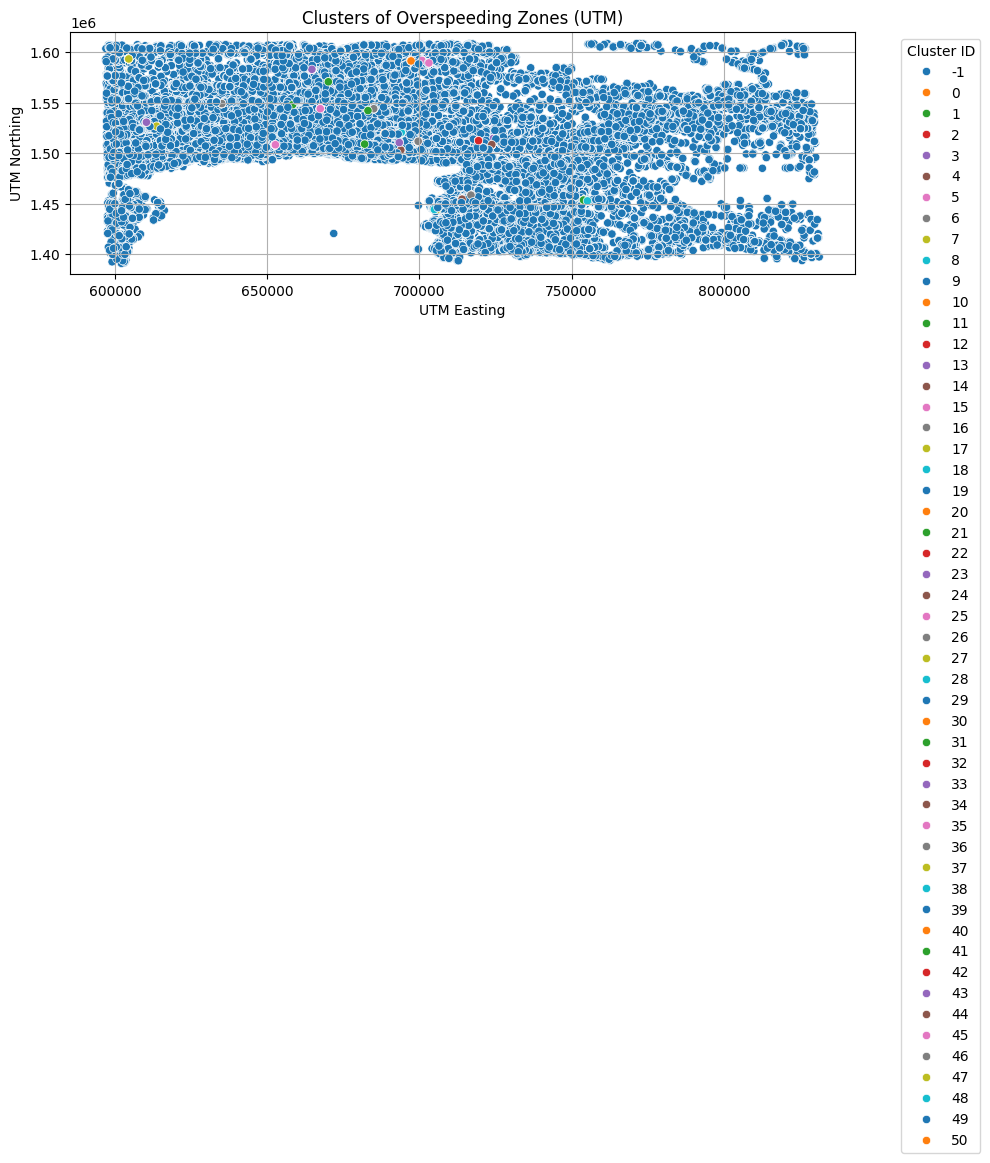

📌 lowspeeding จุดที่พบในแต่ละคลัสเตอร์:
cluster
-1     509081
 13      8006
 0       4502
 16      3669
 5       2956
 22      2917
 2       2767
 3       2344
 25      2219
 36      2107
 12      1943
 21      1643
 35      1633
 26      1600
 31      1540
 42      1417
 14      1366
 32      1357
 9       1306
 40      1225
 7       1163
 30      1148
 38      1018
 45      1001
 27       986
 8        909
 28       889
 23       873
 24       835
 37       830
 46       822
 6        811
 17       796
 47       789
 39       779
 20       775
 15       771
 33       756
 4        745
 29       734
 1        715
 19       698
 44       646
 18       624
 48       591
 49       572
 10       562
 43       560
 50       525
 11       521
 41       519
 34       507
Name: count, dtype: int64


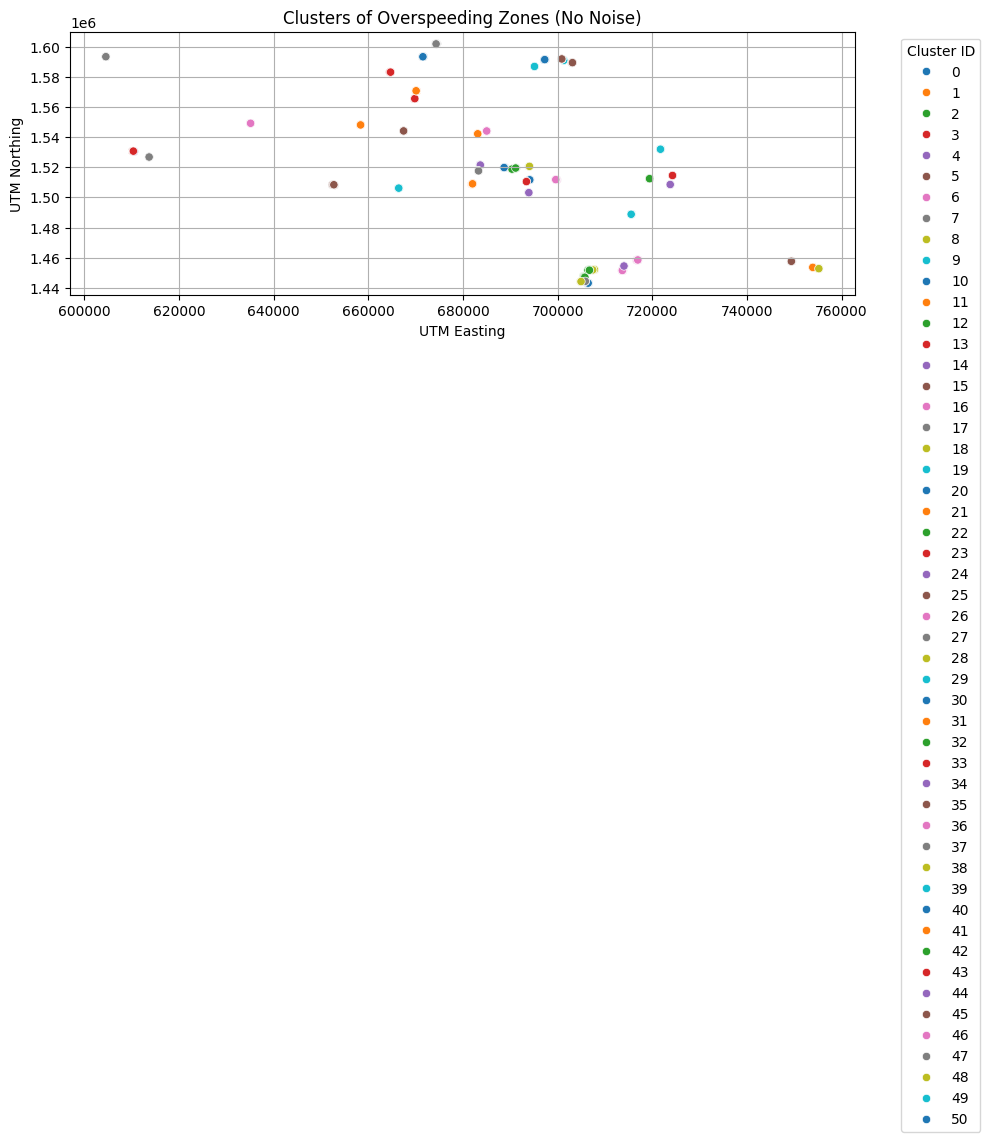

📌 lowspeeding จุดที่พบในแต่ละคลัสเตอร์ (หลังจากกรอง Noise):
cluster
13    8006
0     4502
16    3669
5     2956
22    2917
2     2767
3     2344
25    2219
36    2107
12    1943
21    1643
35    1633
26    1600
31    1540
42    1417
14    1366
32    1357
9     1306
40    1225
7     1163
30    1148
38    1018
45    1001
27     986
8      909
28     889
23     873
24     835
37     830
46     822
6      811
17     796
47     789
39     779
20     775
15     771
33     756
4      745
29     734
1      715
19     698
44     646
18     624
48     591
49     572
10     562
43     560
50     525
11     521
41     519
34     507
Name: count, dtype: int64


In [15]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
#import seaborn as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point


overspeed_df = gdf_utm

# ===== 2. เตรียมข้อมูลพิกัด UTM (ไม่ใช้ lat/lon เพราะ UTM เป็น metric แล้ว) =====
coords = overspeed_df.geometry.apply(lambda p: (p.x, p.y)).tolist()

# ===== 3. Cluster ด้วย DBSCAN =====
# eps=100 (เมตร), min_samples=3 จุดใกล้กันจึงเป็นกลุ่ม
db = DBSCAN(eps=100, min_samples=500).fit(coords)
overspeed_df['cluster'] = db.labels_

# ===== 4. แสดงผลบนกราฟ =====
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=overspeed_df.geometry.x,
    y=overspeed_df.geometry.y,
    hue=overspeed_df['cluster'],
    palette='tab10',
    legend='full'
)
plt.title('Clusters of Overspeeding Zones (UTM)')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.grid(True)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===== 5. สรุปผล =====
print("📌 lowspeeding จุดที่พบในแต่ละคลัสเตอร์:")
print(overspeed_df['cluster'].value_counts())

# ===== 6. กรอง Noise ออกจากข้อมูล =====
no_noise_df = overspeed_df[overspeed_df['cluster'] != -1]

# ===== 7. แสดงผลกราฟใหม่ที่ไม่มี Noise =====
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=no_noise_df.geometry.x,
    y=no_noise_df.geometry.y,
    hue=no_noise_df['cluster'],
    palette='tab10',
    legend='full'
)
plt.title('Clusters of Overspeeding Zones (No Noise)')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.grid(True)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ===== 8. สรุปผลหลังจากกรอง Noise =====
print("📌 lowspeeding จุดที่พบในแต่ละคลัสเตอร์ (หลังจากกรอง Noise):")
print(no_noise_df['cluster'].value_counts())




In [16]:
low_cluster_df = no_noise_df
low_cluster_df

,unitid,utc_ts,lat,lon,speed,typecode,geometry,cluster
35652384,0300006000000000FOX_003_082,2024-11-01 06:53:31,13.741781,100.745502,1,7,POINT (688732.763 1519851.934),0
2881881,0300006000000000FOX_003_863,2024-11-01 00:39:01,14.203440,100.576350,1,7,POINT (670099.446 1570800.194),1
89590535,174000100000000000000002121,2024-11-01 20:26:23,13.085868,100.895658,4,7,POINT (705530.736 1447401.619),2
53875374,030000600000000FOX_002_2084,2024-11-01 10:34:38,13.741899,100.745453,1,7,POINT (688727.369 1519864.951),0
31415474,0300006000000000FOX_002_591,2024-11-01 06:04:36,13.844255,100.021080,1,7,POINT (610346.287 1530737.087),3
...,...,...,...,...,...,...,...,...
81534125,030000600000000FOX_002_1567,2024-11-01 17:59:35,14.388668,100.829633,1,7,POINT (697276.488 1591494.672),30
97639285,0300006000000000FOX_003_543,2024-11-01 22:42:19,13.741641,100.745065,1,7,POINT (688685.611 1519836.103),0
45797522,0300006000000000FOX_003_178,2024-11-01 08:52:15,13.459394,100.990957,1,6,POINT (715537.018 1488811.169),39
84767622,150000200000863835028948490,2024-11-01 18:58:35,13.640530,100.411920,4,7,POINT (652722.191 1508415.128),5


In [20]:
matched_gps_route = gpd.sjoin_nearest(low_cluster_df, polyline_data, distance_col="dist") #max_distance = 
matched_gps_route.reset_index(drop=True, inplace=True)
matched_gps_route

,unitid,utc_ts,lat,lon,speed,typecode,geometry,cluster,index_right,id,section_pa,road_number,control,km_start,km_end,distance,dist
0,0300006000000000FOX_003_082,2024-11-01 06:53:31,13.741781,100.745502,1,7,POINT (688732.763 1519851.934),0,2764,1986,3968,3119,102,5+309,11+003,5.694,114.489802
1,0300006000000000FOX_003_863,2024-11-01 00:39:01,14.203440,100.576350,1,7,POINT (670099.446 1570800.194),1,1125,2160,3748,3309,100,0+000,6+000,6,434.155355
2,0300006000000000FOX_003_863,2024-11-01 00:39:01,14.203440,100.576350,1,7,POINT (670099.446 1570800.194),1,1122,2163,3748,3309,100,0+000,6+000,6,434.155355
3,0300006000000000FOX_003_863,2024-11-01 00:39:01,14.203440,100.576350,1,7,POINT (670099.446 1570800.194),1,1123,2162,3748,3309,100,0+000,6+000,6,434.155355
4,0300006000000000FOX_003_863,2024-11-01 00:39:01,14.203440,100.576350,1,7,POINT (670099.446 1570800.194),1,1124,2161,3748,3309,100,0+000,6+000,6,434.155355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73127,030000600000000FOX_002_1567,2024-11-01 17:59:35,14.388668,100.829633,1,7,POINT (697276.488 1591494.672),30,2900,136,11536,6,200,27+500,43+773,16.273,1100.361092
73128,0300006000000000FOX_003_543,2024-11-01 22:42:19,13.741641,100.745065,1,7,POINT (688685.611 1519836.103),0,2764,1986,3968,3119,102,5+309,11+003,5.694,161.721907
73129,0300006000000000FOX_003_178,2024-11-01 08:52:15,13.459394,100.990957,1,6,POINT (715537.018 1488811.169),39,240,299,5548,34,300,52+900,58+855,5.955,580.563880
73130,150000200000863835028948490,2024-11-01 18:58:35,13.640530,100.411920,4,7,POINT (652722.191 1508415.128),5,489,2541,6179,3902,101,0+000,19+972,19.972,14.013962


In [21]:
grouped_data = matched_gps_route.groupby('cluster').agg({
    'id': lambda x: sorted(set(map(str, x))),
    'section_pa': lambda x: sorted(set(map(str, x))),
    'road_number': lambda x: sorted(set(map(str, x))),
    'control': lambda x: sorted(set(map(str, x))),
}).reset_index()
grouped_data

,cluster,id,section_pa,road_number,control
0,0,[1986],[3968],[3119],[102]
1,1,"[2160, 2161, 2162, 2163]",[3748],[3309],[100]
2,2,[71],[2320],[3],[402]
3,3,[712],[6327],[321],[101]
4,4,[2093],[3394],[3241],[101]
5,5,"[157, 2510, 2541, 300]","[5535, 5900, 6179, 6315]","[35, 3901, 3902, 9]","[100, 101]"
6,6,"[2533, 2560]","[2745, 2761]","[3901, 3902]",[500]
7,7,[2287],[5413],[3467],[100]
8,8,[2428],[2827],[3701],[100]
9,9,[6],[11544],[1],[401]
